In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn_image as isns
import seaborn as sns
import scipy.signal as signal
from scipy import stats

import statsmodels.stats.multitest as smm

from sonar import sonar, utils
import math
import random

from distinctipy import distinctipy

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [5]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'

## Upload sample

In [3]:
relevant_cluster_labels =  [
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan'
]

''' Initial annotations are down below. However 'Endothelial' cells are absent at all, 
'B cell' and 'T cell', are zero in all 4 pancreas samples and 
'background' is excluded from the calculations'''

# cluster_labels = ['background',
#  'Acinar-i',
#  'Acinar-s',
#  'Acinar-REG+',
#  'Activated Stellate',
#  'Quiescent Stellate',
#  'Alpha',
#  'Beta',
#  'Gamma (PP)',
#  'Delta',
#  'Ductal',
#  'MUC5B+ Ductal (PDG)',
#  'MHC Class II',
#  'Schwan',
#  'B cell',
#  'T cell',
# 'Endothelial'
# ]

In [ ]:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(1)]
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()

## Sonar run

In [ ]:
def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

In [ ]:
# For pancreas due to redundant cell types
rescaled = rescaled [1:-2]

In [ ]:
son = sonar.Sonar(labels = relevant_cluster_labels, max_radius=rad_,linear_radius_steps=lin, edge_correction=True, circumference_normalization=True)
cooc_template_  = son.co_occurrence_from_tensor(rescaled,interpolate="linear", area_normalization = False) 

## Normalization

In [ ]:
# I couldn't successfully incorporate the function in the sonar package. That is why I left it here
def normalize_co_occurrence(tensor, sonar_obj, original_img): # when sonar will be fixed, the function will need only sonar obj
    """
    Normalize co-occurrence results based on cell type proportions.

    Args:
        tensor (numpy.ndarray): Co-occurrence tensor to normalize.
        sonar_obj (SonarObject): The SonarObject containing metadata.
        original_img (numpy.ndarray): Original image data.

    Returns:
        normalized_coocur (numpy.ndarray): Normalized co-occurrence tensor.
    """
    
    # Normalisation
    n, _, m = tensor.shape
    normalized_coocur = np.zeros_like(tensor)
    
    for i in range(n):
        for j in range(n):
            for k in range(m):
                normalized_coocur[i, j, k] = tensor[i, j, k] / (son.meta['pixel_counts'].values[j]*son.meta['pixel_proportions'].values[i])

    return normalized_coocur

normalized_coocur = normalize_co_occurrence(tensor=cooc_template_, sonar_obj=son, original_img = rescaled)

# Plotting functions

## 1) Simple plot

In [33]:
def simple_cooc_plot(cooc_curves_res, son,  cell_type = "all", cell_type_labels = relevant_cluster_labels, um_per_px=1.0):#, y_zoom = 0.1): #cell_type_labels should be changed
    """Function for plotting simple co-occurrence plots. 
    Specific cell-types can be selected.

    Parameters:
    - cooc_curves_res (np.nd_array): an array that containes co-occurrence curves, the result of son.co_occurrence_from_tensor() function.
    - son: sonar object
    - cell_type: int or 'all'. 'all' by default to plot all cell types. Can be customized by choosing spesific cell-type number.
    - cell_type_labels: a list of cell-type labels (upd: son.meta)
    - um_per_px: float, um/px scaling parameter.
    """
    fig, ax = plt.subplots()

    ax.set_ylabel("co-occurrence")
    ax.set_xlabel("um") 
   

    if cell_type == "all":
        for i in range(cooc_curves_res.shape[0]): 
            Y = cooc_curves_res[i,i]
            ax.plot(np.arange(len(Y))*um_per_px, Y)
        ax.legend(cell_type_labels, loc="upper right", bbox_to_anchor=(1.45, 1)) # specific case for pancreas, needs to be more general
        ax.set_title(f"Auto-co-occurrence of all cell types")
    else:
        Y = cooc_curves_res[cell_type,cell_type]
        ax.plot(np.arange(len(Y))*um_per_px, Y, label=cell_type_labels[int(cell_type)])
        ax.legend(loc="upper right")
        ax.set_title(f"Auto-co-occurrence of {cell_type_labels[cell_type]} cell-type")


In [ ]:
simple_cooc_plot(cooc_curves_res = normalized_coocur, cell_type_labels = relevant_cluster_labels)

## 2) Co-occurrence with computed radii

In [126]:
def cooc_with_computed_radii(cooc_curves_res, son, cell_type, radii, cell_type_labels = relevant_cluster_labels, um_per_px = 1.0): #cell_type_labels should be changed (con.meta)
    
    """Function for plotting simple co-occurrence plots, the result of a sonar function. 
    Specific cell-types can be selected.

    Parameters:
    - cooc_curves_res: an array that containes co-occurrence curves, the result of son.co_occurrence_from_tensor() function.
    - son: sonar object.
    - cell_type: int, selected cell-type number.
    - rad_: int, selected radii
    - cell_type_labels: a list of cell-type labels.
    - um_per_px: float, um/px scaling parameter.
    """
    fig, ax = plt.subplots()

    ax.set_ylabel("co-occurrence")
    ax.set_xlabel("um")

    Y = cooc_curves_res[cell_type,cell_type]

    ax.plot(np.arange(len(Y))*um_per_px, Y, label=cell_type_labels[int(cell_type)])
    ax.legend(loc="upper right")
    ax.set_title(f"Auto-co-occurrence of {cell_type_labels[cell_type]} cell-type with computed radii")

    # plot radii
    for rad_ in list(range(radii,500,radii)):
        ax.axvline(rad_, linewidth=0.5, color='orange')


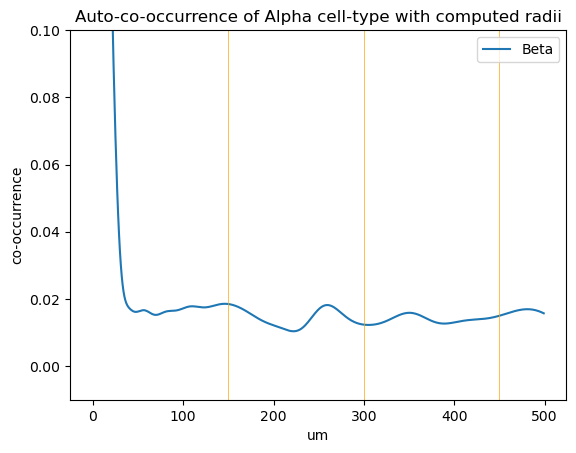

In [127]:
cooc_with_computed_radii(cooc_curves_res=cooc_template_, cell_type=6, radii=150) # the plot is old

## 3) Curve with error margins:

In [588]:
def cooc_with_error_margins(cooc_curves_res, son, cell_type, error_margin, cell_type_labels = relevant_cluster_labels, um_per_px=1.0): #cell_type_labels should be changed (upd: son.meta)
    
    """Function for plotting simple co-occurrence plots, the result of a sonar function. 
    Specific cell-types can be selected.

    Parameters:
    - cooc_curves_res: an array that containes co-occurrence curves, the result of son.co_occurrence_from_tensor() function.
    - son: sonar object.
    - cell_type: int, selected cell-type number.
    - error_margin: float, passed error margin value
    - cell_type_labels: a list of cell-type labels.
    - um_per_px: float, um/px scaling parameter. 
    """
    fig, ax = plt.subplots()

    ax.set_ylabel("co-occurrence")
    ax.set_xlabel("um") 

    Y = cooc_curves_res[cell_type,cell_type]
    X = np.arange(len(Y))*um_per_px # x axis of the plot

    # plots preparation
    initial_plot = Y
    min_error = Y-error_margin
    max_error = Y+error_margin

    # ax.plot(np.arange(len(Y))*um_per_px, Y, label=cell_type_labels[int(cell_type)])

    # margin error plotting
    ax.plot(X, initial_plot, label=cell_type_labels[cell_type], color = 'b')
    ax.plot(X, min_error, color = 'orange', linewidth = 0.001)
    ax.plot(X, max_error, color = 'orange', linewidth = 0.001)
    ax.fill_between(x=X, y1=min_error, y2=max_error, color = 'orange', alpha = 0.5)

    ax.legend(loc="upper right")
    ax.set_title(f"Auto-co-occurrence of {cell_type_labels[cell_type]} cell-type with margin errors")

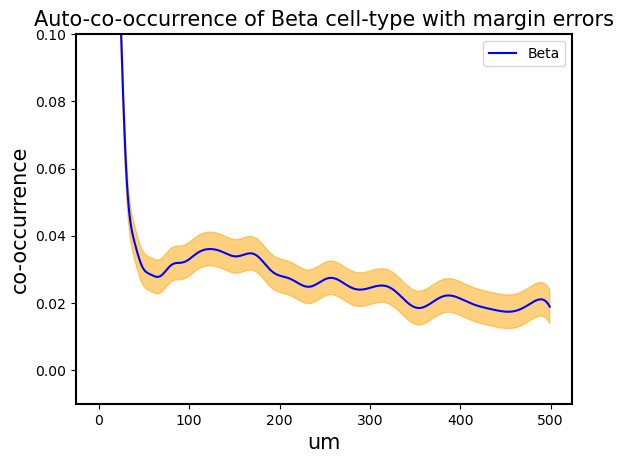

In [589]:
cooc_with_error_margins(cooc_curves_res=cooc_template_, cell_type=6, error_margin=0.005)

## 4) Plot with significance indicatior

In [590]:
# creation of a training set for the future function
# irrelevant for other scales and different um/px
zer_ar = np.zeros(500)
zer_ar[0:60] = 1
zer_ar[190:250] = 1
zer_ar[280:330] = 1
zer_ar[360:420] = 1

bool_ar = zer_ar.astype(bool)

In [591]:
def significance_ident(cooc_curves_res, son, cell_type, bool_array, 
                       cell_type_labels = relevant_cluster_labels, um_per_px=1):
    """
    Indicates 'significant' areas of the co-occurrence plot 
    Parameters:
    - cooc_curves_res: an array that containes co-occurrence curves, the result of son.co_occurrence_from_tensor() function.
    - son: sonar obj
    - cell_type: int number, selected cell type.
    - bool_array: boolean array indicating distances of 'significance'.
    - cell_type_labels: a list of cell-type labels.
    - um_per_px: float, um/px scaling parameter.
    - y_zoom: float, scaling parameter for looking closer at curves, choosing the upper limit of y-axis.
    """

    # preprocessing of the boolean array to recieve edges of highlighted areas
    dist_list = []
    for pos, value in enumerate(bool_ar):
        if value != bool_ar[pos-1]:
            dist_list.append(pos)

    # plotting of the significant areas
    fig, ax = plt.subplots()

    ax.set_ylabel("co-occurrence")
    ax.set_xlabel("um")
    ax.set_title(f"Significance indication plot of {cell_type_labels[cell_type]} cell-type auto-co-occurrence")

    Y = cooc_template_[cell_type,cell_type]
    X = np.arange(len(Y))*um_per_px

    ax.plot(X, Y)

    for i in range(0,len(dist_list),2):

        ax.axvspan(dist_list[i], dist_list[i+1], alpha = 0.3, color = "orange")
    

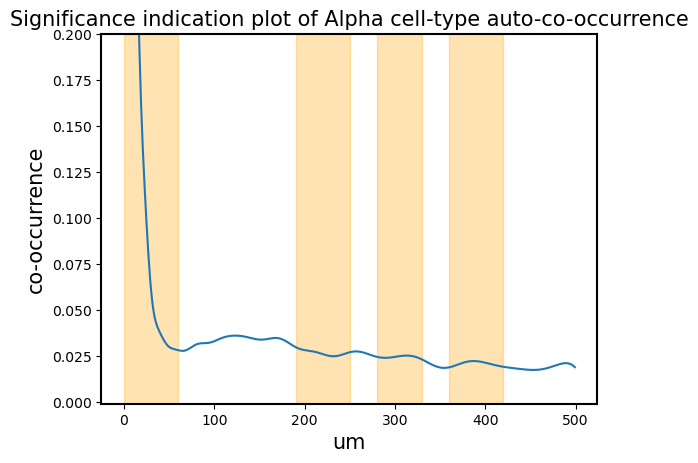

In [593]:
significance_ident(cooc_curves_res = cooc_template_, son=son, cell_type=6, bool_array=bool_ar, 
                       cell_type_labels = cluster_labels)

## 5) stacked local distributions
has issues - not adapted to the new ideas. The calculation should be changed

In [10]:
# calculation of the tissue area of each cell-type
def total_pixel_counts(original_img = rescaled, cell_type_labels = relevant_cluster_labels):

    # fig, ax = plt.figure(figsize=[10,3])

    tissue_pixels = []
    for i in range(len(cell_type_labels)):
        pix_agreg = np.sum(rescaled[i+1]) # rescaled[i+1] because under 0 here is a background
        tissue_pixels.append(pix_agreg)
        # print(pix_agreg)

    # ax.bar(cell_type_labels,tissue_pixels)
    # ax.set_xticks(rotation=45, ha="right")

    # plt.show()

    return list(tissue_pixels)

In [11]:
tissue_pixel_ = son.pixel_counts

In [13]:
def stacked_local_distrib(cooc_curves_res, cell_type, normal_array=None, cell_type_labels = relevant_cluster_labels, um_per_px = 1.0):
                    #cell_type_labels should be changed
    """
    Plots stacked co-occurrence plots which shows their distribution over different distances
    Parameters:
    - cooc_curves_res: an array that containes co-occurrence curves, the result of son.co_occurrence_from_tensor() function.
    - cell_type: int number, selected cell type.
    - normal_array, (list, array): sum of pixels that compose cell-types, the result of total_pixel_counts()
    - cell_type_labels: a list of cell-type labels.
    - um_per_px: float, um/px scaling parameter.
    - show_bg: bool, True by default. Shows the distribution of the background.
    Returns:
    
    """

    # if normalisation array is not provided
    if normal_array == None:
        normal_array = np.ones(cooc_template_.shape[0])


    ct_list = list(range(0,13))
    cell_type_sum = np.zeros(500)
        
    fig, ax = plt.subplots()

    ax.set_ylabel("co-occurrence")
    ax.set_xlabel("um") 
    ax.set_title(f"Stacked local distribution of {cell_type_labels[cell_type]} cell-type VS other cell-types")
    ax.set_ylim(-0.000001, 0.00003)

    # plotting of other cell-types
    for i in ct_list:
        Y = cooc_curves_res[cell_type,i]/normal_array[i]
        X = np.arange(len(Y))*um_per_px
        prev = cell_type_sum.copy()
        cell_type_sum += Y
        ax.fill_between(X,cell_type_sum,prev, alpha = 0.5)
        ax.plot(X , cell_type_sum, label=cell_type_labels[i], linewidth=0.5)

    # get the legend object
    leg = ax.legend(loc='upper right', bbox_to_anchor=(1.45, 1))

    # change the line width for the legend
    for line in leg.get_lines():
        line.set_linewidth(4.0)

    # plt.show()

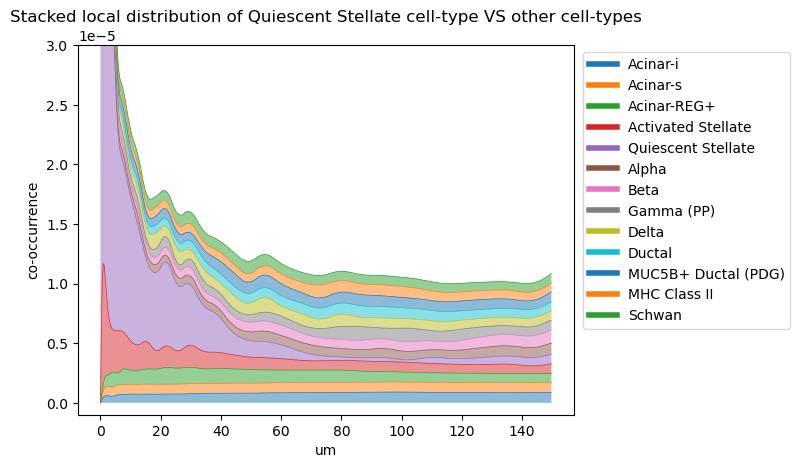

In [15]:
stacked_local_distrib(cooc_template_, 4, normal_array=tissue_pixel_, um_per_px=0.3)
# stacked_local_distrib(cooc_template_, 6)